In [1]:
from casadi import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def timecrossings(arr, times, pos):
    crossings = []
    sign_arr = sign(arr)
    for ii in range(1,len(arr)):
        if sign_arr[ii-1] != sign_arr[ii]:
            if cos(pos[ii]) > -0.99 :
                crossings.append((times[ii-1] + times[ii])/2)
    return crossings

In [3]:
def plot_results(sol, max_par, N):
    arr = sol.value(X)
    timescale_x = np.linspace(0, sol.value(T), N+1)
    timescale_u = np.linspace(0, sol.value(T), N)
    arr_u = sol.value(U)
    plt.figure(figsize=[10,7])
    plt.plot(timescale_x,arr[:,0], label = '$x$')
    plt.plot(timescale_x,arr[:,1], label = "$x'$")
    plt.plot(timescale_u,arr_u[:], label = 'u')
    plt.plot(timescale_x,2+cos(arr[:,0]),':', label = '$2+cos(x)$')
    cross_points = timecrossings(arr[:,1], timescale_x, arr[:,0])
    plt.hlines([0,pi, -pi], 0, timescale_u[-1], 'k', 'dotted')
    plt.hlines([-max_par,max_par], 0, timescale_u[-1], 'r', 'dotted')
    plt.vlines(cross_points, -pi, pi, 'k', 'dotted')
    print(f'Max par: {max_par}, number of crossing points: {len(cross_points)}')
    plt.legend()

## Pendulum exercise
$$
\begin{split}\begin{array}{lc}
\begin{array}{l}
\text{minimize:} \\
x(\cdot) \in \mathbb{R}^2, \, u(\cdot) \in \mathbb{R}
\end{array}
\quad \displaystyle \int_{t=0}^{T}{cos(x_0) \, dt}
\\
\\
\text{subject to:} \\
\\
\begin{array}{ll}
\left\{
\begin{array}{l}
\dot{x}_0 = x_1 \\
\dot{x}_1 = u - sin(x_0) \\
-u_{max} \le u \le u_{max} , \quad
\end{array} \right. & \text{for} \, 0 \le t \le T \\
x_0(0)=0, \quad x_1(0)=0, x_0(T) = pi/2 , x_1(T) = 0
\end{array}
\end{array}\end{split}
$$
with $T=10$.

siendo $$x_0 = \theta$$ $$x_1 = \theta'$$

In [4]:
x = MX.sym('x', 2)
t = MX.sym('t')
dt = MX.sym('dt')
u = MX.sym('u')
y = MX.sym('y')
z = MX.sym('z')

In [5]:
pos_expr = 0.5 * (1 + sign(y))
neg_expr = 0.5 * (1 - sign(y))

pos = Function('pos', [y], [pos_expr])
neg = Function('neg', [y], [neg_expr])

In [6]:
cuad_1 = Function('cuad_1', [x], [pos(x[0]) * pos(x[1])])
cuad_2 = Function('cuad_2', [x], [pos(x[0]) * neg(x[1])])
cuad_3 = Function('cuad_3', [x], [neg(x[0]) * pos(x[1])])
cuad_4 = Function('cuad_4', [x], [neg(x[0]) * neg(x[1])])

In [7]:
s1 = Function('s1', [x, y], [cuad_1(x) * pos(x[0]-y)])
s2 = Function('s2', [x, y], [cuad_1(x) * neg(x[0]-y)])
s3 = Function('s3', [x, y], [cuad_2(x) * pos(x[0]-y)])
s4 = Function('s4', [x, y], [cuad_2(x) * neg(x[0]-y)])
s5 = Function('s5', [x, y], [cuad_3(x) * pos(x[0]-y)])
s6 = Function('s6', [x, y], [cuad_3(x) * neg(x[0]-y)])
s7 = Function('s7', [x, y], [cuad_4(x) * pos(x[0]-y)])
s8 = Function('s8', [x, y], [cuad_4(x) * neg(x[0]-y)])

In [8]:
coefs = MX.sym('coefs', 12)
cortes = MX.sym('cortes', 4)

In [9]:
expr_u = (coefs[0]*s1(x, cortes[0]) + 
          (coefs[1] + x[0]*coefs[2]) * s2(x, cortes[0]) +
          coefs[3]*s3(x, cortes[1]) + 
          (coefs[4] + x[0]*coefs[5]) * s4(x, cortes[1]) +
          coefs[6]*s5(x, cortes[2]) + 
          (coefs[7] + x[0]*coefs[8]) * s6(x, cortes[2]) +
          coefs[9]*s7(x, cortes[3]) + 
          (coefs[10] + x[0]*coefs[11]) * s8(x, cortes[3]))

In [10]:
U = Function('U', [x, coefs, cortes], [expr_u])

k1 = F(x, u);
k2 = F(x + dt/2 * k1, u)
k3 = F(x + dt/2 * k2, u)
k4 = F(x + dt * k3, u);
new_x_expr = x+dt/6*(k1 +2*k2 +2*k3 +k4)

In [11]:
rhs = vertcat(x[1], U(x, coefs, cortes)-sin(x[0]))
#rhs = vertcat(x[1], u)
F = Function('F', [x, coefs, cortes], [rhs])

In [12]:
new_x_expr = x + dt * F(x, coefs, cortes)
new_x = Function('New_x', [x, coefs, cortes, dt], [new_x_expr])

In [13]:
N = 200

In [18]:
x0 = MX.sym('x0', 2)
xit = x0
for ii in range(N):
    xit = new_x(xit, coefs, cortes, dt)

In [19]:
final = Function('final', [x0, coefs, cortes, dt], [xit])

In [20]:
opti = Opti()
opti.solver('ipopt')

In [21]:
Coefs = opti.variable(12)
Cortes = opti.variable(4)
u_arr = opti.variable(N)
T = opti.variable()
u_m = opti.parameter()
x0 = [0,0]

In [22]:
x_f = final(x0, Coefs, Cortes, T/N)

In [23]:
opti.subject_to(opti.bounded(-u_m,Coefs[0],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[3],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[6],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[9],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[1],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[4],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[7],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[10],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[1] + Cortes[0]*Coefs[2],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[4] + Cortes[1]*Coefs[5],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[7] + Cortes[2]*Coefs[8],u_m))
opti.subject_to(opti.bounded(-u_m,Coefs[10] + Cortes[3]*Coefs[11],u_m))

X = opti.variable(N+1,2)
U = opti.variable(N)
T = opti.variable()
u_m = opti.parameter()
#t_m = opti.parameter()

In [24]:
cost = T #sum1(2+cos(X[:,0]))*T #**2
#cost = -sum1(X[:,0])
opti.minimize(cost)

In [25]:
#opti.subject_to(X[0,:].T == [0, 0])
opti.subject_to(cos(x_f[0]) < -0.9999)
#opti.subject_to(T < t_m)
opti.subject_to(opti.bounded(-0.001,x_f[1],0.001))

arr[3,:], new_x(arr[2,:])

for ii in range(N):
    opti.subject_to(X[ii+1,:].T == new_x(X[ii,:], U[ii], T/N))
    opti.subject_to(opti.bounded(-u_m,U[ii],u_m))

In [41]:
opti.set_initial(Coefs, 1)
opti.set_initial(Cortes, 0.1)
opti.set_initial(T, 50)

In [42]:
max_par = 1
opti.set_value(u_m, max_par)

In [43]:
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       54
Number of nonzeros in Lagrangian Hessian.............:      153

Total number of variables............................:       17
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       14
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       13
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  83r 7.2133169e+01 1.73e+00 4.01e+04  -1.7 3.07e-02   5.2 3.72e-02 1.06e-01f  2
  84r 7.2133167e+01 1.73e+00 1.24e+04  -1.7 8.47e-03   4.7 1.00e+00 5.05e-01h  1
  85r 7.2133189e+01 1.75e+00 8.09e+04  -1.7 9.51e-03   4.2 8.00e-03 1.00e+00f  1
  86r 7.2133187e+01 1.72e+00 6.26e+04  -1.7 1.83e-02   3.8 1.00e+00 2.58e-01h  2
  87r 7.2133185e+01 1.74e+00 3.49e+04  -1.7 1.27e-02   4.2 1.00e+00 3.75e-01h  1
  88r 7.2133184e+01 1.73e+00 3.63e+04  -1.7 1.58e-03   3.7 1.00e+00 1.51e-02h  2
  89r 7.2133093e+01 1.73e+00 1.72e+04  -1.7 1.11e-02   3.2 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 7.2133011e+01 1.72e+00 9.62e+04  -1.7 5.30e-05   3.7 1.00e+00 1.00e+00H  1
  91r 7.2133073e+01 1.74e+00 7.08e+04  -1.7 1.37e-03   3.2 1.92e-01 6.59e-02F  1
  92r 7.2133224e+01 1.72e+00 4.02e+04  -1.7 1.62e-01   2.7 2.23e-04 4.49e-03f  5
  93r 7.2133223e+01 1.76e+00 2.05e+05  -1.7 2.15e-03   5.9 6.71e-01 1.00e+00f  1
  94r 7.2133223e+01 1.75e+00

 179r 7.2133799e+01 1.71e+00 1.19e+05  -1.7 3.33e-03   5.5 8.15e-03 1.22e-06h 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 7.2133799e+01 1.72e+00 1.14e+05  -1.7 5.96e-03   5.9 1.25e-01 4.81e-03f  6
 181r 7.2133802e+01 1.74e+00 6.63e+04  -1.7 6.58e-03   5.4 2.18e-03 2.25e-01f  1
 182r 7.2133802e+01 1.73e+00 4.72e+04  -1.7 6.26e-03   4.9 1.00e+00 1.54e-01f  1
 183r 7.2133801e+01 1.73e+00 3.66e+04  -1.7 5.96e-03   4.5 1.00e+00 8.66e-02h  1
 184r 7.2133757e+01 1.72e+00 1.21e+05  -1.7 8.27e-05   4.0 1.00e+00 1.00e+00f  1
 185r 7.2133779e+01 1.76e+00 9.27e+04  -1.7 5.54e-04   3.5 2.16e-01 4.00e-02h  2
 186r 7.2133779e+01 1.73e+00 4.97e+03  -1.7 7.53e-03   5.7 2.02e-02 1.16e-01f  2
 187r 7.2133781e+01 1.73e+00 2.18e+04  -1.7 8.18e-04   5.3 1.00e+00 1.00e+00h  1
 188r 7.2133780e+01 1.75e+00 1.03e+04  -1.7 4.24e-03   4.8 1.00e+00 4.19e-01h  1
 189r 7.2133790e+01 1.74e+00 3.86e+04  -1.7 4.00e-04   4.3 2.16e-01 1.00e+00f  1
iter    objective    inf_pr 

 275r 7.2135967e+01 1.73e+00 4.60e+03  -1.7 5.94e-04   3.9 6.87e-01 2.11e-01H  1
 276r 7.2135994e+01 1.72e+00 1.35e+04  -1.7 1.83e-03   3.4 9.10e-01 1.00e+00h  1
 277r 7.2135423e+01 1.75e+00 1.22e+05  -1.7 1.34e-03   3.0 1.00e+00 1.00e+00F  1
 278r 7.2135424e+01 1.71e+00 1.85e+05  -1.7 3.88e-03   6.1 2.03e-01 3.89e-01f  1
 279r 7.2135424e+01 1.73e+00 1.25e+05  -1.7 4.50e-03   5.6 2.10e-01 1.16e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 7.2135418e+01 1.74e+00 2.01e+05  -1.7 4.77e-03   5.1 1.00e+00 1.00e+00h  1
 281r 7.2135419e+01 1.75e+00 5.82e+05  -1.7 1.61e-03   6.5 4.16e-01 1.00e+00f  1
 282r 7.2135419e+01 1.75e+00 5.10e+05  -1.7 2.99e-03   6.0 6.28e-01 9.05e-02H  1
 283r 7.2135418e+01 1.71e+00 3.94e+05  -1.7 3.87e-03   5.5 1.00e+00 1.97e-01h  1
 284r 7.2135409e+01 1.72e+00 2.31e+05  -1.7 3.59e-03   5.0 1.00e+00 1.00e+00h  1
 285r 7.2135409e+01 1.75e+00 2.19e+05  -1.7 1.07e-03   6.4 5.10e-01 1.00e+00f  1
 286r 7.2135409e+01 1.74e+00

 369r 7.2333134e+01 1.72e+00 1.00e+04  -1.7 1.57e-03   5.2 4.40e-01 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r 7.2333137e+01 1.73e+00 2.95e+04  -1.7 8.86e-03   4.7 1.00e+00 5.00e-01f  2
 371r 7.2333135e+01 1.72e+00 1.40e+04  -1.7 1.07e-02   4.3 1.00e+00 2.35e-01h  2
 372r 7.2333127e+01 1.72e+00 4.54e+03  -1.7 5.90e-03   3.8 1.00e+00 4.29e-01h  1
 373r 7.2333155e+01 1.76e+00 1.51e+04  -1.7 1.48e-04   3.3 5.99e-01 1.00e+00f  1
 374r 7.2333155e+01 1.72e+00 1.41e+04  -1.7 4.99e-03   3.7 1.00e+00 3.45e-02h  1
 375r 7.2333040e+01 1.72e+00 4.55e+04  -1.7 1.23e-04   3.3 1.00e+00 1.00e+00f  1
 376r 7.2333313e+01 1.74e+00 9.07e+03  -1.7 1.04e-03   2.8 2.20e-01 2.63e-01h  2
 377r 7.2333309e+01 1.74e+00 6.71e+03  -1.7 3.59e-03   3.2 1.00e+00 7.08e-02h  1
 378r 7.2333297e+01 1.74e+00 4.72e+03  -1.7 1.83e-04   2.7 1.00e+00 6.25e-02f  5
 379r 7.2333275e+01 1.73e+00 6.31e+03  -1.7 1.18e-04   3.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 462r 7.2411984e+01 1.75e+00 1.74e+05  -1.7 3.39e-03   6.0 2.33e-01 4.86e-01f  2
 463r 7.2411984e+01 1.73e+00 1.67e+05  -1.7 2.21e-03   5.6 1.00e+00 2.56e-02h  1
 464r 7.2411978e+01 1.75e+00 2.68e+05  -1.7 3.14e-03   5.1 8.33e-01 1.00e+00h  1
 465r 7.2411979e+01 1.73e+00 6.72e+05  -1.7 1.70e-03   6.4 2.78e-01 1.00e+00f  1
 466r 7.2411979e+01 1.74e+00 6.24e+05  -1.7 2.35e-03   5.9 1.00e+00 5.02e-02h  1
 467r 7.2411975e+01 1.75e+00 4.23e+05  -1.7 4.14e-03   5.5 8.31e-01 1.00e+00h  1
 468r 7.2411976e+01 1.72e+00 9.49e+05  -1.7 5.04e-04   6.8 3.24e-01 1.00e+00F  1
 469r 7.2411976e+01 1.72e+00 7.36e+05  -1.7 8.52e-04   6.3 1.00e+00 1.43e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470r 7.2411975e+01 1.73e+00 3.47e+05  -1.7 1.12e-03   5.8 1.00e+00 1.00e+00h  1
 471r 7.2411978e+01 1.73e+00 1.14e+06  -1.7 1.73e-03   6.3 2.49e-01 1.00e+00F  1
 472r 7.2411978e+01 1.74e+00 9.44e+05  -1.7 2.74e-03   5.8 1.00e+00 9.68e-02h  1
 473r 7.2411972e+01 1.73e+00

 559r 7.3161679e+01 1.74e+00 6.15e+03  -1.7 1.01e-02   4.9 1.00e+00 2.07e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560r 7.3161679e+01 1.75e+00 5.33e+03  -1.7 1.38e-04   4.4 8.29e-01 7.54e-02h  2
 561r 7.3161706e+01 1.76e+00 4.12e+03  -1.7 7.00e-03   4.0 1.00e+00 1.00e+00f  1
 562r 7.3161706e+01 1.75e+00 2.49e+03  -1.7 1.43e-02   3.5 1.00e+00 2.53e-01h  2
 563r 7.3161708e+01 1.72e+00 1.64e+03  -1.7 9.19e-03   3.0 1.00e+00 1.99e-01h  2
 564r 7.3161766e+01 1.73e+00 5.26e+03  -1.7 2.17e-03   2.5 1.00e+00 4.26e-01h  2
 565r 7.3163019e+01 1.73e+00 5.71e+03  -1.7 1.40e-03   2.1 4.75e-01 1.00e+00h  1
 566r 7.3163019e+01 1.76e+00 3.49e+03  -1.7 9.82e-03   3.4 1.00e+00 1.18e-01h  2
 567r 7.3163017e+01 1.75e+00 2.45e+03  -1.7 6.39e-03   2.9 1.00e+00 9.19e-02h  2
 568r 7.3162984e+01 1.74e+00 5.70e+03  -1.7 9.28e-04   2.4 1.00e+00 3.76e-01h  2
 569r 7.3164248e+01 1.74e+00 1.03e+04  -1.7 1.26e-03   2.0 5.50e-01 1.00e+00h  1
iter    objective    inf_pr 

 655r 7.3227839e+01 1.73e+00 4.43e+05  -1.7 1.29e-02   5.8 1.34e-01 5.05e-01f  1
 656r 7.3227839e+01 1.73e+00 4.42e+05  -1.7 4.24e-03   5.3 1.00e+00 1.26e-03h  5
 657r 7.3227839e+01 1.73e+00 4.42e+05  -1.7 3.00e-03   4.8 2.40e-02 1.30e-04h 11
 658r 7.3227836e+01 1.75e+00 7.32e+04  -1.7 6.95e-03   5.2 1.00e+00 4.79e-01h  1
 659r 7.3227827e+01 1.75e+00 1.45e+05  -1.7 2.10e-04   4.8 9.63e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660r 7.3227830e+01 1.75e+00 5.15e+05  -1.7 4.31e-03   6.1 2.02e-01 8.29e-01f  1
 661r 7.3227830e+01 1.74e+00 5.14e+05  -1.7 3.87e-03   5.6 1.00e+00 2.17e-03h  4
 662r 7.3227830e+01 1.74e+00 5.13e+05  -1.7 1.57e-03   5.1 2.87e-02 8.24e-04h  8
 663r 7.3227816e+01 1.74e+00 2.28e+05  -1.7 8.04e-03   4.6 1.00e+00 1.00e+00h  1
 664r 7.3227819e+01 1.73e+00 4.14e+05  -1.7 3.71e-03   6.0 3.45e-01 1.00e+00f  1
 665r 7.3227819e+01 1.73e+00 4.14e+05  -1.7 1.59e-03   5.5 9.37e-01 8.19e-04h  6
 666r 7.3227812e+01 1.72e+00

 753r 7.3230582e+01 1.72e+00 9.33e+03  -1.7 5.77e-04   3.8 1.00e+00 5.97e-02h  5
 754r 7.3230486e+01 1.75e+00 7.83e+03  -1.7 2.38e-04   3.3 1.00e+00 1.00e+00h  1
 755r 7.3230659e+01 1.75e+00 5.38e+04  -1.7 1.47e-03   2.8 1.78e-01 1.00e+00h  1
 756r 7.3230658e+01 1.75e+00 6.28e+04  -1.7 1.01e-02   4.2 1.00e+00 8.57e-02h  2
 757r 7.3230658e+01 1.74e+00 5.18e+04  -1.7 8.74e-03   3.7 1.00e+00 5.01e-02h  2
 758r 7.3230658e+01 1.73e+00 5.17e+04  -1.7 2.49e-03   4.1 7.82e-01 2.78e-03h  7
 759r 7.3230588e+01 1.76e+00 7.42e+04  -1.7 2.70e-03   3.6 1.33e-01 9.38e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760r 7.3230590e+01 1.75e+00 9.23e+04  -1.7 1.16e-02   5.9 1.16e-01 2.16e-01f  1
 761r 7.3230590e+01 1.73e+00 8.14e+04  -1.7 4.48e-03   5.4 1.00e+00 6.26e-02h  1
 762r 7.3230576e+01 1.72e+00 2.90e+05  -1.7 6.04e-04   4.9 3.45e-01 1.00e+00h  1
 763r 7.3230576e+01 1.72e+00 1.32e+05  -1.7 8.51e-03   6.2 1.10e-01 5.29e-02f  2
 764r 7.3230576e+01 1.73e+00

 846r 7.3064465e+01 1.74e+00 1.37e+04  -1.7 2.25e-04   3.7 1.00e+00 1.22e-04h 14
 847r 7.3064209e+01 1.72e+00 8.17e+04  -1.7 3.65e-04   3.2 1.00e+00 1.00e+00F  1
 848r 7.3064226e+01 1.73e+00 7.82e+04  -1.7 3.11e-03   2.8 1.86e-01 5.36e-03f  3
 849r 7.3064226e+01 1.73e+00 4.10e+04  -1.7 5.60e-03   5.9 1.19e-02 9.09e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850r 7.3064227e+01 1.73e+00 4.57e+03  -1.7 9.81e-03   5.4 3.86e-01 1.06e-01f  3
 851r 7.3064228e+01 1.75e+00 8.39e+02  -1.7 2.05e-03   4.9 7.32e-01 1.25e-01h  4
 852r 7.3064230e+01 1.75e+00 1.66e+03  -1.7 2.09e-03   4.5 1.00e+00 4.33e-01h  2
 853r 7.3064229e+01 1.73e+00 4.16e+03  -1.7 3.52e-03   4.0 1.00e+00 7.72e-01h  1
 854r 7.3052558e+01 1.73e+00 5.69e+02  -1.7 9.30e-02    -  1.24e-01 2.50e-01f  3
 855r 7.3052556e+01 1.76e+00 3.44e+03  -1.7 5.31e-03   3.5 1.00e+00 1.00e+00f  1
 856r 7.3052587e+01 1.74e+00 4.63e+04  -1.7 6.76e-01   3.9 8.17e-03 3.64e-02f  2
 857r 7.3052574e+01 1.74e+00

 939r 7.3056546e+01 1.74e+00 3.54e+04  -1.7 6.02e-04   3.6 1.00e+00 5.91e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940r 7.3056526e+01 1.76e+00 1.21e+05  -1.7 3.40e-04   4.1 1.00e+00 1.00e+00h  1
 941r 7.3056562e+01 1.74e+00 6.86e+04  -1.7 1.43e-03   3.6 1.78e-01 8.89e-02f  2
 942r 7.3056568e+01 1.77e+00 6.36e+04  -1.7 5.92e-01   4.9 4.79e-04 8.34e-03f  2
 943r 7.3056566e+01 1.72e+00 3.27e+04  -1.7 1.15e-02   4.4 1.00e+00 2.25e-01h  2
 944r 7.3056566e+01 1.73e+00 2.31e+04  -1.7 9.22e-03   4.0 1.00e+00 1.42e-01h  2
 945r 7.3056563e+01 1.76e+00 1.59e+04  -1.7 6.25e-03   3.5 1.00e+00 1.05e-01h  2
 946r 7.3056556e+01 1.77e+00 2.97e+04  -1.7 1.14e-03   3.9 1.00e+00 5.83e-01h  1
 947r 7.3056727e+01 1.76e+00 1.51e+05  -1.7 3.37e-04   3.4 1.97e-01 7.44e-01H  1
 948r 7.3056727e+01 1.76e+00 1.47e+05  -1.7 6.53e-03   4.8 1.00e+00 7.04e-03h  2
 949r 7.3056722e+01 1.74e+00 9.68e+04  -1.7 2.96e-04   4.3 1.49e-01 9.37e-02f  2
iter    objective    inf_pr 

1033r 7.3063063e+01 1.75e+00 1.44e+04  -1.7 4.40e-03   3.0 1.00e+00 2.14e-02f  2
1034r 7.3063022e+01 1.77e+00 3.55e+04  -1.7 1.04e-03   3.5 1.00e+00 4.46e-01F  1
1035r 7.3063057e+01 1.73e+00 2.38e+04  -1.7 3.62e-03   3.0 3.37e-01 6.38e-02f  3
1036r 7.3063107e+01 1.76e+00 1.29e+04  -1.7 4.44e-03   2.5 8.49e-03 3.96e-02f  5
1037r 7.3063116e+01 1.76e+00 8.87e+04  -1.7 2.21e-02   4.7 8.83e-01 4.89e-01f  1
1038r 7.3063116e+01 1.74e+00 9.93e+04  -1.7 1.61e-02   4.3 1.00e+00 7.03e-03h  2
1039r 7.3063110e+01 1.76e+00 1.05e+05  -1.7 1.51e-02   4.7 1.00e+00 7.15e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040r 7.3063110e+01 1.75e+00 1.06e+05  -1.7 1.63e-03   4.2 6.60e-02 5.29e-03h  3
1041r 7.3063110e+01 1.74e+00 7.18e+04  -1.7 1.38e-02   5.5 3.28e-02 3.07e-02f  2
1042r 7.3063111e+01 1.74e+00 7.04e+04  -1.7 1.68e-03   6.0 7.39e-01 8.96e-03h  7
1043r 7.3063111e+01 1.74e+00 6.29e+04  -1.7 6.55e-03   5.5 1.99e-02 1.95e-03h 10
1044r 7.3063111e+01 1.74e+00

1127r 7.3068341e+01 1.76e+00 9.97e+02  -1.7 1.59e-11  13.8 1.00e+00 1.00e+00h  1
1128r 7.3068341e+01 1.76e+00 9.97e+02  -1.7 4.77e-11  13.3 1.00e+00 1.00e+00h  1
1129r 7.3068341e+01 1.76e+00 9.97e+02  -1.7 1.43e-10  12.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130r 7.3068341e+01 1.76e+00 9.97e+02  -1.7 4.29e-10  12.4 1.00e+00 1.00e+00f  1
1131r 7.3068341e+01 1.76e+00 9.97e+02  -1.7 1.29e-09  11.9 1.00e+00 7.81e-03h  8
1132r 7.3068341e+01 1.76e+00 9.97e+02  -1.7 3.86e-09  11.4 1.00e+00 6.10e-05f 15
1133r 7.3068341e+01 1.76e+00 9.97e+02  -1.7 1.16e-08  10.9 1.00e+00 3.81e-06h 19
1134r 7.3068341e+01 1.76e+00 9.97e+02  -1.7 3.48e-08  10.5 1.00e+00 4.77e-07h 22
1135r 7.3068341e+01 1.76e+00 9.97e+02  -1.7 1.04e-07  10.0 1.00e+00 5.96e-08h 25
1136r 7.3068341e+01 1.73e+00 9.97e+02  -1.7 3.13e-07   9.5 1.00e+00 1.49e-08h 27
1137r 7.3068341e+01 1.73e+00 9.97e+02  -1.7 1.10e-05   9.0 0.00e+00 1.16e-10R 34
1138r 7.3068341e+01 1.73e+00

1223r 6.8752483e+01 1.17e+01 4.22e+12  -1.7 1.50e-02  12.3 3.09e-02 8.91e-03h  1
1224r 6.8752487e+01 1.09e+01 3.23e+14  -1.7 1.59e-02  12.8 4.31e-01 3.45e-01f  2
1225r 6.8752487e+01 1.09e+01 3.22e+14  -1.7 1.86e-02  15.9 3.11e-04 1.46e-04h  2
1226r 6.8752487e+01 1.09e+01 3.20e+14  -1.7 1.87e-02  16.3 3.10e-03 1.12e-04h  2
1227r 6.8752486e+01 1.09e+01 2.19e+16  -1.7 1.86e-02  15.9 1.88e-05 9.93e-03f  1
1228r 6.8752486e+01 1.09e+01 2.19e+16  -1.7 2.00e-02  18.1 5.98e-01 2.71e-05h  2
1229r 6.8752470e+01 1.14e+01 4.86e+19  -1.7 1.99e-02  17.6 2.73e-03 4.05e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230r 6.8752470e+01 1.14e+01 4.86e+19  -1.7 1.99e-02  20.0 0.00e+00 0.00e+00R  1
Restoration phase is called at point that is almost feasible,
  with constraint violation 3.418218e-16. Abort.
Restoration phase in the restoration phase failed.

Number of Iterations....: 1230

                                   (scaled)                 (unscaled)
Objec

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Restoration_Failed'

Max par: 0.1, number of crossing points: 5


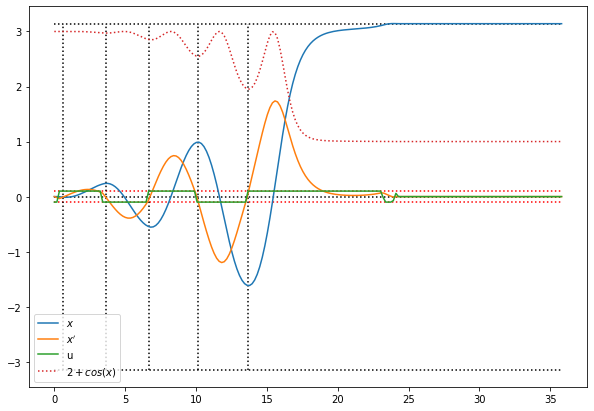

In [18]:
plot_results(sol, max_par, N)

In [19]:
results = []
for ii in [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]:
    opti.set_value(u_m, ii)
    est_t = (2 + sqrt(1/ii))*8
    opti.set_initial(T, est_t)
    try:
        sol = opti.solve()
    except:
        pass
    else:
        results.append([sol, ii, N])

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1802
Number of nonzeros in inequality constraint Jacobian.:      202
Number of nonzeros in Lagrangian Hessian.............:      802

Total number of variables............................:      603
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      402
Total number of inequality constraints...............:      202
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      201
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  26  9.1986234e+03 1.16e-03 1.58e+02  -1.0 7.53e-01   0.9 7.09e-01 4.52e-01f  1
  27  9.1843163e+03 1.33e-03 1.55e+02  -1.0 5.75e+00   0.4 5.92e-03 2.26e-02f  1
  28  9.1505589e+03 1.38e-03 8.97e+01  -1.0 6.49e-01   0.9 7.35e-01 3.77e-01f  1
  29  9.1183146e+03 2.44e-03 8.80e+01  -1.0 7.22e+00   0.4 3.37e-03 4.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.1100566e+03 2.25e-03 5.86e+01  -1.0 4.95e-01   0.8 6.33e-01 8.83e-02f  1
  31  9.0845908e+03 2.67e-03 5.47e+01  -1.0 3.85e+00   0.3 6.24e-03 9.90e-02f  1
  32  9.0586836e+03 2.06e-03 3.95e+01  -1.0 3.95e-01    -  2.81e-01 2.75e-01f  1
  33  9.0168835e+03 2.33e-03 2.42e+01  -1.0 6.03e-01   0.8 3.68e-01 6.14e-01f  1
  34  8.9905529e+03 4.56e-04 3.38e+00  -1.0 2.22e-01   1.2 1.00e+00 1.00e+00f  1
  35  8.9763841e+03 5.56e-04 3.33e+00  -1.0 6.35e-01   0.7 2.82e-01 1.75e-01f  1
  36  8.9534051e+03 5.24e-04 2.44e+00  -1.0 1.80e-01   1.1 1.00e+00 1.00e+00f  1
  37  8.9300631e+03 8.24e-04

 131  7.5793425e+03 2.72e-04 3.45e+01  -1.7 3.32e-01   0.8 6.69e-01 5.51e-01f  1
 132  7.5712623e+03 4.30e-04 1.91e+01  -1.7 2.22e+00   0.3 1.93e-02 1.09e-01f  1
 133  7.5628404e+03 3.22e-04 4.36e+01  -1.7 2.95e-01   0.7 7.58e-01 4.63e-01f  1
 134  7.5593447e+03 3.19e-04 4.70e+01  -1.7 1.04e+00   0.3 1.20e-01 6.39e-02f  1
 135  7.5463523e+03 3.20e-04 1.90e+01  -1.7 3.13e-01   0.7 9.12e-01 8.31e-01f  1
 136  7.5381643e+03 4.34e-04 1.89e+01  -1.7 2.61e+00   0.2 1.07e-02 6.69e-02f  1
 137  7.5333213e+03 3.47e-04 8.73e+00  -1.7 2.90e-01   0.6 4.64e-01 2.71e-01f  1
 138  7.5261425e+03 4.54e-04 5.24e+01  -1.7 3.28e+01   0.2 7.41e-04 6.29e-03f  1
 139  7.5204945e+03 3.63e-04 1.86e+02  -1.7 6.00e-01   0.6 6.75e-01 2.81e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  7.5181795e+03 3.79e-04 1.43e+02  -1.7 3.96e+00   0.1 3.05e-03 2.13e-02f  1
 141  7.5037703e+03 5.24e-04 4.93e+01  -1.7 4.44e-01   0.5 3.46e-01 6.81e-01f  1
 142  7.5020045e+03 5.22e-04

  18  1.3223338e+04 1.11e-02 1.92e+02  -1.0 2.12e-01   2.0 6.84e-01 1.53e-01f  1
  19  1.3167091e+04 9.84e-03 1.79e+02  -1.0 1.01e+00   1.5 1.84e-01 1.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3152076e+04 8.30e-03 2.08e+02  -1.0 2.21e-01   2.0 3.68e-01 1.62e-01f  1
  21  1.3133553e+04 7.75e-03 2.04e+02  -1.0 5.62e-01   1.5 2.18e-01 6.80e-02f  1
  22  1.3140082e+04 4.90e-03 2.74e+02  -1.0 2.33e-01   1.9 1.00e+00 3.91e-01h  1
  23  1.3131774e+04 4.28e-03 2.36e+02  -1.0 5.96e-01   1.4 1.62e-01 1.28e-01f  1
  24  1.3158055e+04 3.28e-03 1.70e+02  -1.0 4.18e-01   1.9 1.67e-01 2.38e-01h  1
  25  1.3146827e+04 2.68e-03 2.11e+02  -1.0 8.60e-01   1.4 3.44e-01 1.85e-01f  1
  26  1.3150282e+04 2.57e-03 1.92e+02  -1.0 4.85e-01   0.9 8.52e-02 4.00e-02h  1
  27  1.3196490e+04 1.17e-03 3.04e+02  -1.0 2.93e-01   2.2 1.00e+00 5.58e-01h  1
  28  1.3238485e+04 3.04e-04 2.27e+02  -1.0 2.03e-01    -  5.65e-01 1.00e+00h  1
  29  1.3239761e+04 3.06e-05

  51  1.6679459e+04 5.54e-03 7.59e+01  -1.0 3.32e-01   0.9 3.57e-01 2.27e-01f  1
  52  1.6669117e+04 6.47e-03 1.09e+02  -1.0 1.16e+01   0.4 1.37e-03 9.33e-03f  1
  53  1.6661291e+04 5.53e-03 9.76e+01  -1.0 2.91e-01    -  2.12e-01 1.68e-01f  1
  54  1.6653910e+04 4.73e-03 3.91e+01  -1.0 3.83e-01   0.9 6.68e-01 2.05e-01f  1
  55  1.6639684e+04 7.95e-04 2.15e+00  -1.0 1.13e-01   1.3 1.00e+00 1.00e+00f  1
  56  1.6634165e+04 8.30e-04 4.00e+01  -1.0 6.72e-01    -  1.66e-01 4.42e-02f  1
  57  1.6626284e+04 9.53e-04 4.95e+01  -1.0 3.70e-01   0.8 4.54e-01 2.11e-01f  1
  58  1.6608704e+04 2.93e-03 1.18e+02  -1.0 3.21e+00   0.3 8.34e-03 4.90e-02f  1
  59  1.6592364e+04 1.63e-03 3.51e+01  -1.0 1.58e-01    -  4.02e-01 5.14e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.6586963e+04 1.73e-03 1.00e+01  -1.0 6.36e-01   0.8 4.50e-01 1.24e-01f  1
  61  1.6579681e+04 9.87e-04 1.99e+00  -1.0 1.06e-01   1.2 1.00e+00 1.00e+00f  1
  62  1.6575477e+04 1.04e-03

 168  1.5977253e+04 6.09e-04 8.36e+01  -2.5 4.71e-01   0.7 4.14e-02 1.91e-01f  1
 169  1.5977237e+04 6.09e-04 7.64e+01  -2.5 4.14e-01    -  9.82e-02 7.19e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.5974592e+04 2.38e-04 1.28e+00  -2.5 9.91e-02   1.1 1.00e+00 9.95e-01f  1
 171  1.5974260e+04 1.91e-04 2.67e+01  -2.5 1.04e-02    -  4.10e-01 1.99e-01f  1
 172  1.5972897e+04 2.13e-05 7.46e-01  -2.5 2.16e-02   1.5 1.00e+00 1.00e+00f  1
 173  1.5971378e+04 6.72e-05 1.83e+01  -2.5 1.39e-01    -  1.39e-01 2.59e-01f  1
 174  1.5969348e+04 1.09e-04 5.35e+01  -2.5 1.33e-01   1.1 9.16e-01 3.12e-01f  1
 175  1.5968514e+04 2.48e-05 7.34e+01  -2.5 4.59e-02   1.5 3.75e-01 1.00e+00f  1
 176  1.5964790e+04 2.44e-04 2.75e+01  -2.5 1.12e-01   1.0 3.23e-01 4.99e-01f  1
 177  1.5951336e+04 1.32e-03 7.45e+01  -2.5 3.61e-01   0.5 8.00e-02 3.47e-01f  1
 178  1.5949712e+04 1.14e-03 5.72e+01  -2.5 1.25e-01   1.0 1.00e+00 1.62e-01f  1
 179  1.5949244e+04 1.14e-03

  52  2.1425456e+04 8.69e-03 7.61e+01  -1.0 5.26e+00   1.1 2.61e-01 5.57e-02f  1
  53  2.1341243e+04 8.58e-03 7.59e+01  -1.0 1.33e+01   0.7 3.50e-02 1.64e-02f  1
  54  2.1180880e+04 7.95e-03 7.57e+01  -1.0 5.55e+00   1.1 1.14e-02 7.72e-02f  1
  55  2.1166492e+04 7.92e-03 7.55e+01  -1.0 1.00e+01   0.6 1.73e-02 3.83e-03f  1
  56  2.1093077e+04 7.71e-03 7.56e+01  -1.0 6.86e+00   1.0 1.11e-01 2.81e-02f  1
  57  2.1018863e+04 7.68e-03 7.56e+01  -1.0 1.93e+01   0.6 3.07e-03 9.54e-03f  1
  58  2.0915539e+04 7.57e-03 1.01e+02  -1.0 1.48e+01   1.0 1.46e-01 1.78e-02f  1
  59  2.0868908e+04 7.40e-03 9.94e+01  -1.0 5.91e+00   0.5 2.44e-02 2.30e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.0798746e+04 7.30e-03 9.76e+01  -1.0 1.25e+01   0.9 7.01e-03 1.43e-02f  1
  61  2.0775927e+04 7.22e-03 1.07e+02  -1.0 5.60e+00   0.5 3.71e-02 1.21e-02f  1
  62  2.0625335e+04 1.67e-02 8.13e+01  -1.0 1.00e+01  -0.0 4.49e-02 5.62e-02f  1
  63  2.0591231e+04 1.66e-02

  37  3.7847490e+04 3.67e-01 2.58e+03  -1.0 2.24e+00   3.8 1.13e-02 3.99e-02f  1
  38  3.7846808e+04 3.67e-01 3.72e+03  -1.0 2.00e+00   4.2 2.02e-02 3.76e-04h  1
  39  3.7784548e+04 3.52e-01 3.20e+03  -1.0 2.01e+00   3.7 3.58e-03 4.13e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.7775974e+04 3.50e-01 4.78e+03  -1.0 1.82e+00   4.2 4.04e-02 5.78e-03f  1
  41  3.7752918e+04 3.43e-01 4.65e+03  -1.0 1.81e+00   3.7 5.11e-03 1.90e-02f  1
  42  3.7668826e+04 3.22e-01 4.33e+03  -1.0 1.73e+00   4.1 4.80e-02 5.99e-02f  1
  43  3.7670484e+04 3.22e-01 4.34e+03  -1.0 5.75e+00   3.6 7.49e-02 1.06e-03h  1
  44  3.7665656e+04 3.21e-01 5.13e+03  -1.0 1.54e+00   4.1 5.29e-02 4.31e-03f  1
  45  3.7625663e+04 3.10e-01 6.95e+03  -1.0 1.53e+00   4.5 5.70e-02 3.33e-02f  1
  46  3.7420612e+04 2.43e-01 7.50e+03  -1.0 1.45e+00   4.0 1.06e-01 2.15e-01f  1
  47  3.7413495e+04 2.40e-01 7.73e+03  -1.0 1.04e+00   4.4 4.01e-02 1.11e-02f  1
  48  3.7402641e+04 2.35e-01

 155  2.2922903e+04 3.61e-04 1.55e+02  -2.5 1.18e-01   1.2 1.00e+00 1.60e-01f  1
 156  2.2922590e+04 2.73e-04 3.91e+02  -2.5 1.14e-02    -  7.53e-01 2.47e-01f  1
 157  2.2921917e+04 4.82e-04 3.91e+02  -2.5 8.05e-01   0.7 4.68e-04 5.31e-02f  1
 158  2.2921935e+04 4.52e-04 6.47e+02  -2.5 3.14e-02    -  1.00e+00 6.25e-02f  5
 159  2.2921403e+04 2.26e-04 3.07e+02  -2.5 1.08e-02    -  4.28e-01 5.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  2.2920937e+04 2.53e-04 2.32e+02  -2.5 1.01e-01   1.1 1.00e+00 2.63e-01f  1
 161  2.2920467e+04 3.75e-07 2.30e-02  -2.5 3.18e-03    -  1.00e+00 1.00e+00f  1
 162  2.2919232e+04 7.04e-06 1.93e+00  -3.8 8.42e-03    -  8.35e-01 9.05e-01f  1
 163  2.2919097e+04 9.85e-09 6.50e-06  -3.8 3.44e-03    -  1.00e+00 1.00e+00f  1
 164  2.2919022e+04 4.07e-09 2.47e-01  -5.7 3.18e-03    -  8.34e-01 1.00e+00f  1
 165  2.2919021e+04 2.41e-10 3.70e-02  -5.7 2.96e-03    -  8.50e-01 1.00e+00h  1
 166  2.2919021e+04 6.32e-11

Max par: 0.5, number of crossing points: 2
Max par: 0.2, number of crossing points: 3
Max par: 0.1, number of crossing points: 5
Max par: 0.05, number of crossing points: 7
Max par: 0.02, number of crossing points: 7
Max par: 0.01, number of crossing points: 8


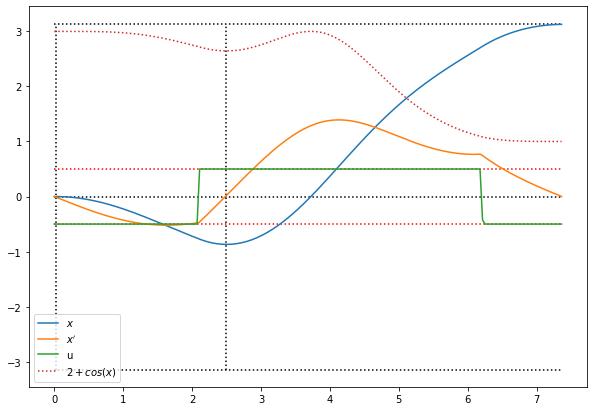

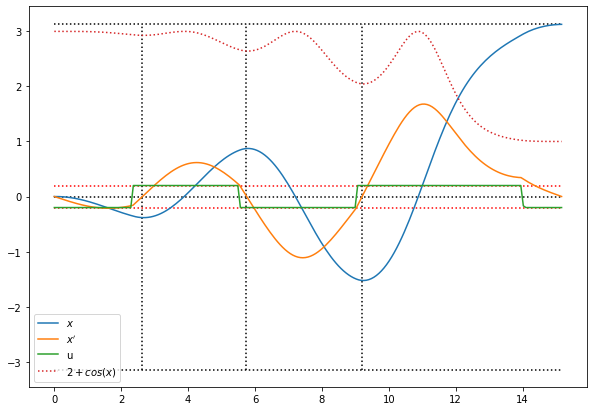

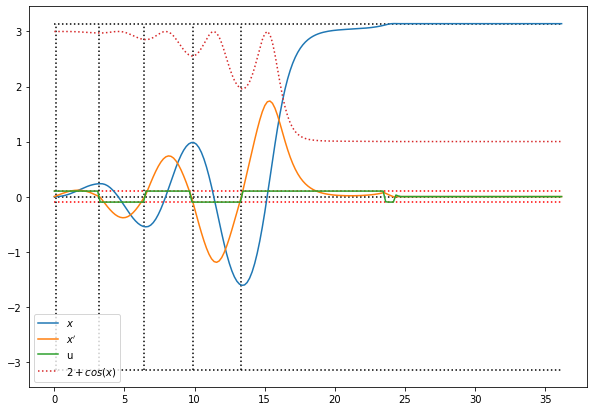

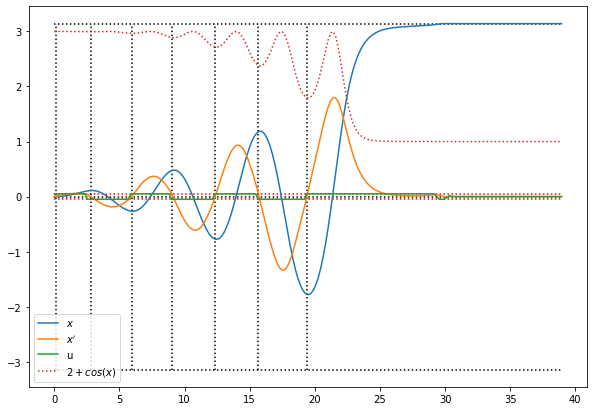

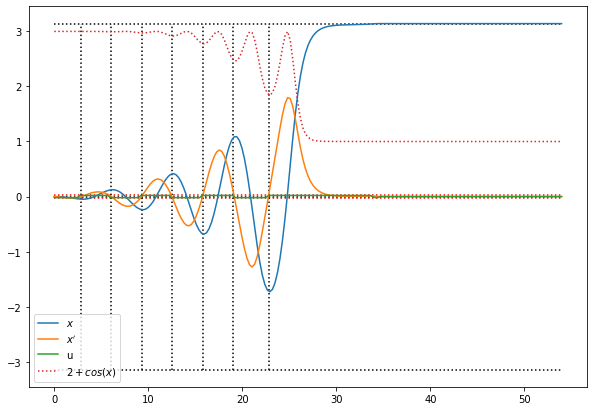

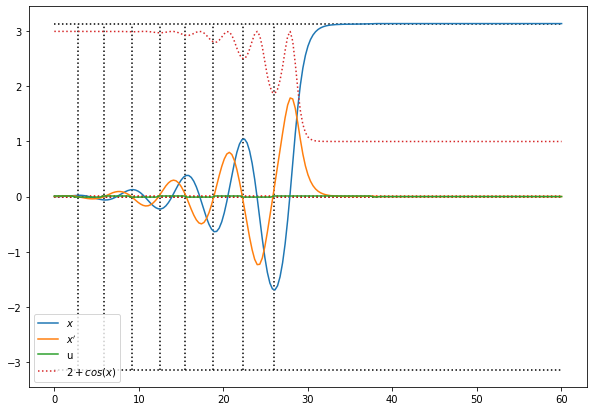

In [20]:
for res in results:
    plot_results(*res)

In [21]:
xx = np.array([1,0.5, 0.2, 0.1, 0.05, 0.02])
yy = np.array([1,2,3,5,6,8])

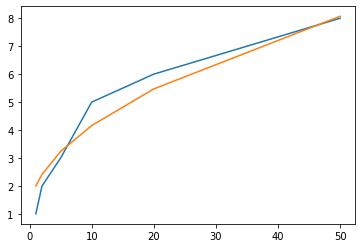

In [22]:
plt.plot(1/xx,yy)
#pp = np.arange(50)
pp = 1/xx
plt.plot(pp,1 + np.sqrt(pp))

In [23]:
opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 0/604 ------ 
0 <= 6.43043e-38 <= 0 (viol 6.43043e-38)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-13-90c9789babde>:1
At nonzero 0.
------- i = 1/604 ------ 
0 <= 1.89753e-37 <= 0 (viol 1.89753e-37)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-13-90c9789babde>:1
At nonzero 1.
------- i = 4/604 ------ 
0 <= -1.63496e-37 <= 0 (viol 1.63496e-37)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 5/604 ------ 
0 <= 4.33681e-19 <= 0 (viol 4.33681e-19)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 6/604 ------ 
-0.01 <= 0.01 <= 0.01 (viol 9.9995e-09

Opti constraint of shape 1x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:3
------- i = 148/604 ------ 
0 <= 2.77556e-17 <= 0 (viol 2.77556e-17)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 149/604 ------ 
0 <= -2.77556e-17 <= 0 (viol 2.77556e-17)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 150/604 ------ 
-0.01 <= 0.01 <= 0.01 (viol 9.99635e-09)
Opti constraint of shape 1x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:3
------- i = 151/604 ------ 
0 <= -5.55112e-17 <= 0 (viol 5.55112e-17)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2

0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 285/604 ------ 
-0.01 <= 0.01 <= 0.01 (viol 9.9882e-09)
Opti constraint of shape 1x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:3
------- i = 286/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 287/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 288/604 ------ 
-0.01 <= 0.01 <= 0.01 (viol 9.98632e-09)
Opti constraint of shape 1x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:3
-------

------- i = 466/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 467/604 ------ 
0 <= 3.67806e-17 <= 0 (viol 3.67806e-17)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 469/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 470/604 ------ 
0 <= 3.66982e-17 <= 0 (viol 3.66982e-17)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 472/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casad

In [24]:
for ii in xx:
    print(ii, (2 + sqrt(1/ii))*8)

1.0 24.0
0.5 27.31370849898476
0.2 33.88854381999832
0.1 41.29822128134704
0.05 51.77708763999664
0.02 72.5685424949238
